# Collect and Analyze a Twitter Network
[Effrosyni Simou](http://lts4.epfl.ch/simou), *PhD Student*, [EPFL](http://epfl.ch) [LTS4](http://lts4.epfl.ch)

# Objective of Exercise
The aim of this exercise is to learn how to create your own, real network using data collected from the Internet and then to discover some properties of the collected network. 

# Resources
You might want to have a look at the following resources before starting:

* [Twitter REST API](https://dev.twitter.com/rest/public)
* [Tweepy Documentation](http://tweepy.readthedocs.io/en/v3.5.0/)
* [Tutorial "Mining Twitter data with Python"](https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/)

# 1. Collect a Twitter Network

In order to collect data from Twitter you will need to generate access tokens.  To do this you will need to register a [client application with Twitter](https://apps.twitter.com/). Once you are done you should have your tokens. You can now create a `credentials.ini` file as follows:
```
[twitter]
consumer_key = YOUR-CONSUMER-KEY
consumer_secret = YOUR-CONSUMER-SECRET
access_token = YOUR-ACCESS-TOKEN
access_secret = YOUR-ACCESS-SECRET
```
In this way you will have this information readily available to you. 

In [1]:
%matplotlib inline
import time
import random
import configparser
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import tweepy  # you will need to install tweepy first

In [2]:
# Read the confidential token.
credentials = configparser.ConfigParser()
credentials.read('credentials.ini')

#authentication
auth = tweepy.OAuthHandler(credentials.get('twitter', 'consumer_key'), credentials.get('twitter', 'consumer_secret'))
auth.set_access_token(credentials.get('twitter', 'access_token'), credentials.get('twitter', 'access_secret'))

#construct API instance
#deal with rate limits and notify when delayed because of rate limits
api = tweepy.API(auth,wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Now you are all set up to start collecting data from Twitter! 

In this exercise we will construct a network with the following logic:

1) We will chose a `user_id` in Twitter to be our first node. 

2) We will find (some) of the users who are both following `user_id` and are being followed by `user_id`. From now on we will call such users "connections" of `user_id`. We will place these user ids in a list called `first_nodes`. 

3) For every node in the list `first_nodes` we will then find (some) of the users who are following and are being followed by this node (aka the connections of this node). The user ids collected in this step will be placed in a list called `second_nodes`.

4) The collection of the ids of all nodes (aka Twitter users) that we have collected so far will be placed in a list called `all_nodes`.

5) Since we have only collected a subset of all possible "connections" for our nodes we have to check if there are any remaining inner connections that we have missed.

The entire network is to be organized in a dictionary with entries that will have as key the Twitter id of the user (this is a number characterizing each user in Twitter) and as value the list of ids of his connections.

So, let us begin. The first thing that you will have to do is to chose the node from which everything will start. I have chosen the Twitter account of [Applied Machine Learning Days](https://www.appliedmldays.org) that will take place in January 2018 in EPFL. You may change that if you wish to, but please make sure that the user you chose has both followers and friends and that he allows you to access this data.

In [3]:
user = 'appliedmldays '
user_id=api.get_user(user).id

In the following cell write a function that takes as an argument the Twitter id of a user and returns a list with the **ids** of his connections. Take into account the case where a user does not allow you to access this information.

**Reminder:** By connections we mean users that are both followers and friends of a given user.

In [4]:
def find_connections(user_id):
    followers = []
    friends=[]
    #your code here
    for page in tweepy.Cursor(api.followers_ids, user_id = user_id).pages():
        followers.extend(page)
        time.sleep(60)
    for page in tweepy.Cursor(api.friends_ids, user_id = user_id).pages():
        friends.extend(page)
        time.sleep(60)
    connections = list(set(followers) & set(friends))
    return connections

In [5]:
first_connections = find_connections(user_id)
print('{}has {} connections'.format(user, len(first_connections)))

appliedmldays has 139 connections


Collect your `first_nodes` and `second_nodes` and organize your collected nodes and their connections in the dictionary called `network`.

Hints:
* Use `random.choice([1,3,4])` to randomly choose a number in `[1, 3, 4]`.
* Use the `append` and `remove` methods to add and remove an element from a Python list.
* The `pop` method removes the last item in the list.

In [6]:
#Sample code to show the usage of random.shuffle()

#Instead of iteratively smapling the connections using random.choice, I will randomly shuffle the connection list
#using random.shuffle and then choose the first 'how_many' elements.

#This avoids the possibility of same node/connection being chosen twice.

x = [x for x in range(10)]
print('Original List :')
print(x)
random.shuffle(x)
print('Shuffled List :')
print(x)

Original List :
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Shuffled List :
[9, 5, 6, 1, 8, 2, 0, 7, 3, 4]


In [7]:
network={}
first_nodes=[]
second_nodes=[]
how_many=5      #This is the number of connections you are sampling. 
                #Keep small (e.g.3) for development, larger later (e.g. 10)
#your code here

random.shuffle(first_connections)
first_nodes = first_connections[0:how_many] #Choosing 'how_many' nodes from total connections.

second_connections = []

for i, node in enumerate(first_nodes):
    second_connections.append(find_connections(node))  #Saving the entire second connection for each first node for later use
    random.shuffle(second_connections[i])              
    second_nodes.append(second_connections[i][0:how_many])  #Choosing 'how_many' nodes from total connections
                                                            #and storing them as 2D list so as to associate them with their
                                                            #corresponding parent node.
                                                            #P.S. Note that second connections have been stored as
                                                            #2D list for the same reason.

In [8]:
print('First Nodes :')
print(first_nodes)
print('Second Nodes :')
print(second_nodes)

First Nodes :
[24250587, 1275985766, 4066214715, 1106304776, 45099110]
Second Nodes :
[[1910529589, 40438400, 10993742, 1372516554, 2330574824], [717368511350198272, 3111698671, 18078296, 809274300033155072, 733251835], [1562961949, 836649919393976320, 1626842281, 788312323337363456, 124117158], [1073360120, 261704941, 747542150561341440, 195301167, 2297587010], [2685273937, 3513224901, 760815330923077633, 93399497, 796666787215667200]]


**Be careful!** You should only keep a small value for the `how_many` parameter while you are developing your code. In order to answer to the questions you should raise the value of this parameter to `how_many=10` at least. This will take a while to execute because of the API rate limit (plan your time accordingly). You should also remember to submit your jupyter notebook with the **output shown for a large value of the `how_many` parameter**. 

In [9]:
network[user_id] = first_nodes #Creating root node for graph.

In [10]:
pprint(network)

{763052115392593920: [24250587, 1275985766, 4066214715, 1106304776, 45099110]}


In [11]:
#Since second nodes are stored as 2D list, I unravel them to iterate more easily.
second_nodes_flat = [x for sublist in second_nodes for x in sublist]
print(second_nodes_flat)

#Finding third connections of all second_nodes.
third_connections = []
for i, node in enumerate(second_nodes_flat):
    print(i)
    third_connections.append(find_connections(node))

[1910529589, 40438400, 10993742, 1372516554, 2330574824, 717368511350198272, 3111698671, 18078296, 809274300033155072, 733251835, 1562961949, 836649919393976320, 1626842281, 788312323337363456, 124117158, 1073360120, 261704941, 747542150561341440, 195301167, 2297587010, 2685273937, 3513224901, 760815330923077633, 93399497, 796666787215667200]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [12]:
print(len(third_connections))

25


In [13]:
u_id = [user_id]
all_nodes = list(set(first_nodes) | set(second_nodes_flat) | set(u_id)) #Creating the list all_nodes.
print(all_nodes)

[40438400, 717368511350198272, 809274300033155072, 836649919393976320, 788312323337363456, 747542150561341440, 760815330923077633, 796666787215667200, 1106304776, 763052115392593920, 1562961949, 124117158, 1626842281, 195301167, 1910529589, 4066214715, 2297587010, 3513224901, 93399497, 1372516554, 10993742, 2685273937, 18078296, 24250587, 45099110, 1275985766, 2330574824, 261704941, 3111698671, 1073360120, 733251835]


In [14]:
print('There are {} first hop nodes'.format(len(first_nodes)))
#print('There are {} second hop nodes'.format(len(second_nodes)))
print('There are {} second hop nodes'.format(len(second_nodes_flat)))
print('There are overall {} nodes in the collected network'.format(len(all_nodes)))

There are 5 first hop nodes
There are 25 second hop nodes
There are overall 31 nodes in the collected network


In [15]:
for i, node in enumerate(first_nodes):
    network[node] = second_nodes[i]    #Extending the network by including branches of first node.
pprint(network)

{24250587: [1910529589, 40438400, 10993742, 1372516554, 2330574824],
 45099110: [2685273937,
            3513224901,
            760815330923077633,
            93399497,
            796666787215667200],
 1106304776: [1073360120, 261704941, 747542150561341440, 195301167, 2297587010],
 1275985766: [717368511350198272,
              3111698671,
              18078296,
              809274300033155072,
              733251835],
 4066214715: [1562961949,
              836649919393976320,
              1626842281,
              788312323337363456,
              124117158],
 763052115392593920: [24250587, 1275985766, 4066214715, 1106304776, 45099110]}


In [16]:
for node in second_nodes_flat:
    if (node != user_id and node not in first_nodes):
        network[node]=[]    #Currently, not going beyond the second nodes.
pprint(network)

{10993742: [],
 18078296: [],
 24250587: [1910529589, 40438400, 10993742, 1372516554, 2330574824],
 40438400: [],
 45099110: [2685273937,
            3513224901,
            760815330923077633,
            93399497,
            796666787215667200],
 93399497: [],
 124117158: [],
 195301167: [],
 261704941: [],
 733251835: [],
 1073360120: [],
 1106304776: [1073360120, 261704941, 747542150561341440, 195301167, 2297587010],
 1275985766: [717368511350198272,
              3111698671,
              18078296,
              809274300033155072,
              733251835],
 1372516554: [],
 1562961949: [],
 1626842281: [],
 1910529589: [],
 2297587010: [],
 2330574824: [],
 2685273937: [],
 3111698671: [],
 3513224901: [],
 4066214715: [1562961949,
              836649919393976320,
              1626842281,
              788312323337363456,
              124117158],
 717368511350198272: [],
 747542150561341440: [],
 760815330923077633: [],
 763052115392593920: [24250587, 1275985766, 4066214715, 

Find the inner connections between your collected nodes that you might have missed because you sampled the connections.

In [17]:
for node in second_nodes_flat:
    if node in first_connections:                      #Inner connection between second node and root node.
        network[node].append(user_id)
    for i in range(len(second_connections)):           #Inner connection between second node and some other first node
        sc = second_connections[i]                     #which might not be the parent node.
        if node in sc:
            network[node].append(first_nodes[i])
    for j in range(len(third_connections)):            #Inner connection between two different second nodes.
        tc = third_connections[j]
        if node in tc:
            network[node].append(second_nodes_flat[j])

In [18]:
for node in first_nodes:                               
    for i in range(len(second_connections)):           #Inner connection between two different first nodes
        sc = second_connections[i]
        if node in sc:
            network[node].append(first_nodes[i])

In [19]:
pprint(network)

{10993742: [24250587],
 18078296: [1275985766],
 24250587: [1910529589, 40438400, 10993742, 1372516554, 2330574824],
 40438400: [24250587, 2330574824],
 45099110: [2685273937,
            3513224901,
            760815330923077633,
            93399497,
            796666787215667200],
 93399497: [45099110],
 124117158: [4066214715],
 195301167: [763052115392593920, 1106304776],
 261704941: [1106304776, 747542150561341440],
 733251835: [1275985766],
 1073360120: [1106304776],
 1106304776: [1073360120, 261704941, 747542150561341440, 195301167, 2297587010],
 1275985766: [717368511350198272,
              3111698671,
              18078296,
              809274300033155072,
              733251835],
 1372516554: [24250587, 1910529589, 2330574824],
 1562961949: [4066214715],
 1626842281: [4066214715],
 1910529589: [24250587, 1372516554, 2330574824],
 2297587010: [1106304776, 747542150561341440],
 2330574824: [24250587, 1910529589, 40438400, 1372516554],
 2685273937: [45099110],
 3111698671

# 2. Discover some of the properties of the collected network

## 2.1 Adjacency matrix

Congradulations! You have now created a dictionary that describes a real Twitter network!
We now want to transform this dictionary into the adjacency (or weight) matrix that you learned about in your first class. 

In [20]:
W=np.zeros([len(all_nodes),len(all_nodes)], dtype=int)

In [21]:
# your code here
for i in range(len(all_nodes)):
    for node in network[all_nodes[i]]:
        j = all_nodes.index(node)
        W[i][j] = 1
        W[j][i] = 1   #If i is connection of j, then j is also connection of i.

Remember that a weight matrix should be symmetric. Check if it is:

In [22]:
np.nonzero(W-W.transpose())

(array([], dtype=int64), array([], dtype=int64))

**Question 1:**
It might happen that $W \neq W^{T} $ for some $(i,j)$. Explain why this might be the case.

**Your answer here:** My adjacency matrix is already symmetric.

Impose your weight matrix to be symmetric.

In [ ]:
# Make W is symmetric
bigger = W.transpose() > W

In [ ]:
W = W - W*bigger + W.transpose()*bigger

Plot the weight matrix of your collected network.

Hint: use `plt.spy()` to visualize a matrix.

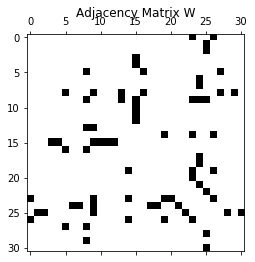

In [23]:
# your code here
plt.title('Adjacency Matrix W')
plt.spy(W)

**Question 2:**
What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your collected network)? How many links $L$ are there in your collected network? Comment on how $L$ and $L_{max}$ compare.

**Your answer here:**

Theoretically,
$L_{max} = \frac{N * (N - 1)}{2}$

In [24]:
N = W.shape[0]
L_max = N * (N - 1) / 2
print(L_max)

465.0


$L$ can be counted from the adjacency matrix as total number of ones in the upper triangular part of the matrix.

In [25]:
L = sum(sum(W)) / 2
print(L)

37.0


Obviously, $L << L_{max}$.
This is because, in real world, everyone doesn't know everyone else.

## 2.2 Degrees distribution

Plot a histogram of the degree distribution. 

In [26]:
k = W.sum(axis = 0)             #Take sum across rows of W (a.k.a vertically), k[i] would be the degree of node i.
k_range = np.zeros((N-1))
support = np.array([x for x in range(N-1)])
for ele in k:
    k_range[ele] += 1
k_range /= N

<Container object of 30 artists>

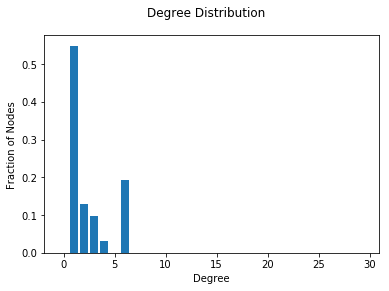

In [27]:
fig = plt.figure()
fig.suptitle('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Fraction of Nodes')
plt.bar(support, height = k_range)

**Question 3:** Comment on the plot. What do you observe? Would you expect a similar degree disribution in the complete Twitter network?

**Your answer here:** The network here seems to have a large number of nodes with less degree and fewer nodes with high degree. The complete Twitter network would likely be scale free and follow the power law, meaning that hubs in the network wouldn't be uncommon. Since I have taken only two layers down my root node and further sampled them down, hence this distribution isn't representative of the power law because data is too less. With more number of nodes, hubs would be visible more and more.

## 2.3 Average degree

Calculate the average degree of your collected network.

In [35]:
d_avg1 = (2 * L) / N
d_avg2 = sum(support*k_range)
print('Average Degree calculated using formula: {}'.format(d_avg1))
print('Average Degree calculated using adjacency matrix: {}'.format(d_avg2))

Average Degree calculated using formula: 2.3870967741935485
Average Degree calculated using adjacency matrix: 2.387096774193548


## 2.4 Diameter of the collected network

**Question 4:** What is the diameter of the collected network? Please justify.

**Your answer here:** As we can see from the output of the cell below, the diameter of network is 4. This is because the maximum distance between 2 nodes from the second layer would be one hop to the first layer, next hop to the root node, next hop back to some other node in first layer and a final hop to the destination node in second layer. Hence, 4 hops is completely justified.

In [36]:
import networkx as nx

In [49]:
G = nx.from_numpy_matrix(W)
diameter = nx.diameter(G)
print('Diameter is {}'.format(diameter))

Diameter is 4


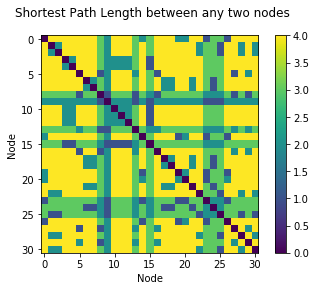

In [50]:
import scipy

fig = plt.figure()
fig.suptitle('Shortest Path Length between any two nodes')
plt.xlabel('Node')
plt.ylabel('Node')
plt.imshow(scipy.sparse.csgraph.shortest_path(W, directed = False))
plt.colorbar()

## 2.5 Pruning the collected network

You might notice that some nodes have very few connections and hence our matrix is very sparse. Prune the collected network so that you keep only the nodes that have a degree that is greater than the average degree and plot the new adjacency matrix.

In [31]:
del_indices = np.where(k <= d_avg1)
print(del_indices)

(array([ 0,  1,  2,  3,  4,  6,  7, 10, 11, 12, 13, 16, 17, 18, 20, 21, 22,
       27, 28, 29, 30], dtype=int64),)


In [32]:
Wpruned = W
for i in del_indices:
    w1 = np.delete(Wpruned, i, 0)
    w1 = np.delete(w1, i, 1)
    Wpruned = w1
Wpruned.shape

(10, 10)

In [33]:
#Wpruned = # your code here

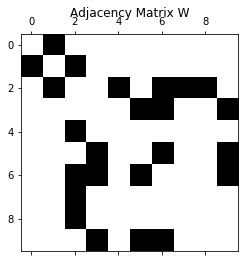

In [34]:
#plt.spy(Wpruned, markersize=1)
plt.spy(Wpruned)
plt.title('Adjacency Matrix W');